# Avocado Time-series

It is well known that millennials love avocado toasts. It is well known that millennials live with their parents. In fact, they can't buy their own house because they eat too much avocado toast. But there is hope. If we can find a town with cheap avocados, millennials can move there and save up for their own apartments. That's what we're going to do in this project!

In [2]:
import numpy as np
import pandas as pd

from scipy import stats 

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

import seaborn as sns
%matplotlib inline
import sktime

In [3]:
import warnings 
warnings.filterwarnings('ignore')

## Data

Data taken from [the Kaggle competition.](https://www.kaggle.com/neuromusic/avocado-prices) The table below shows monthly avocado retail sales data:

* `Date` - date of observation
* `AveragePrice` - average price per avocado
* `Type` - Regular or organic
* `Year` - year
* `Region` - city or region of observation

In addition to these columns, there are several other technical columns, but we will not be interested in them. m

In [4]:
dff = pd.read_csv('avocado_small.tsv', sep='\t', parse_dates=['Date']).set_index('Date')

dff.index = dff.index.to_period("M")

dff = dff[dff.Type == 'organic'] 
print(dff.shape)
dff.head()

(2105, 4)


,AveragePrice,Region,Year,Type
Date,,,,
2015-12,1.84,Albany,2015,organic
2015-11,1.88,Albany,2015,organic
2015-10,1.98,Albany,2015,organic
2015-09,1.86,Albany,2015,organic
2015-08,2.00,Albany,2015,organic


Let's look at how the price of avocados has changed from year to year in different cities.

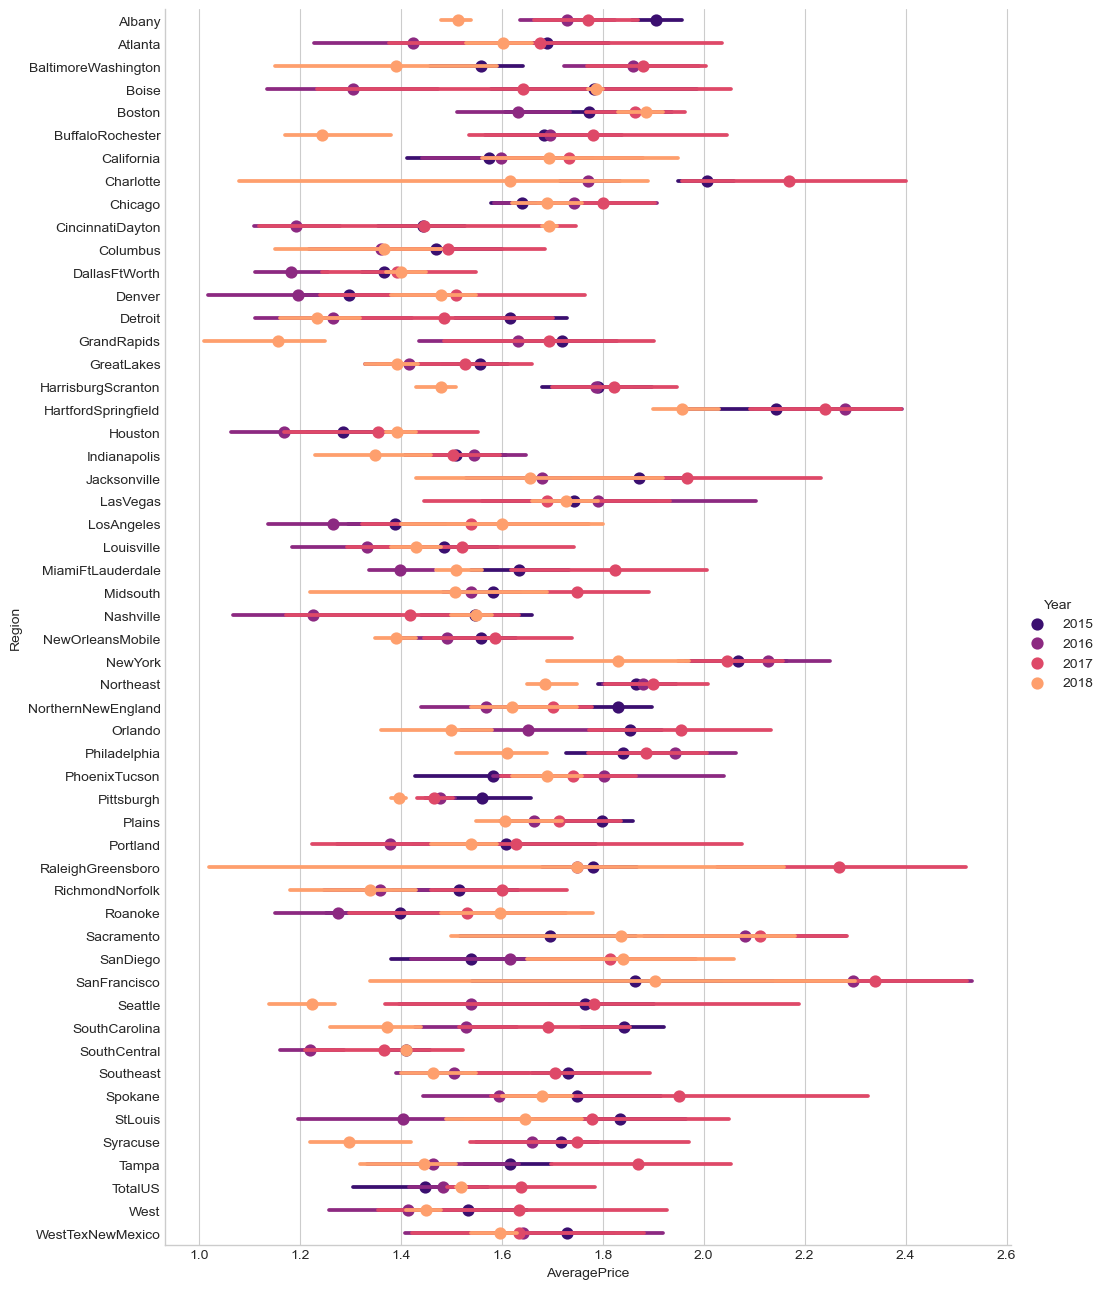

In [5]:
sns.factorplot('AveragePrice', 'Region', data=dff, hue='Year',
                size=13, aspect=0.8, palette='magma', join=False);

It seems that San Francisco is definitely not a good fit. Apparently, millennials can be saved by Houston.

In [6]:
df = dff[['AveragePrice', 'Region']]
df.head()

,AveragePrice,Region
Date,,
2015-12,1.84,Albany
2015-11,1.88,Albany
2015-10,1.98,Albany
2015-09,1.86,Albany
2015-08,2.00,Albany


In [7]:
df.index.unique().size # 39 unqiue points

39

In [8]:
df.Region.unique().size # 54 unique cities

54

We will work with Boston. Let's split the sample into train and test. Using the `plot_series` function, let's look at this partitioning

27 12


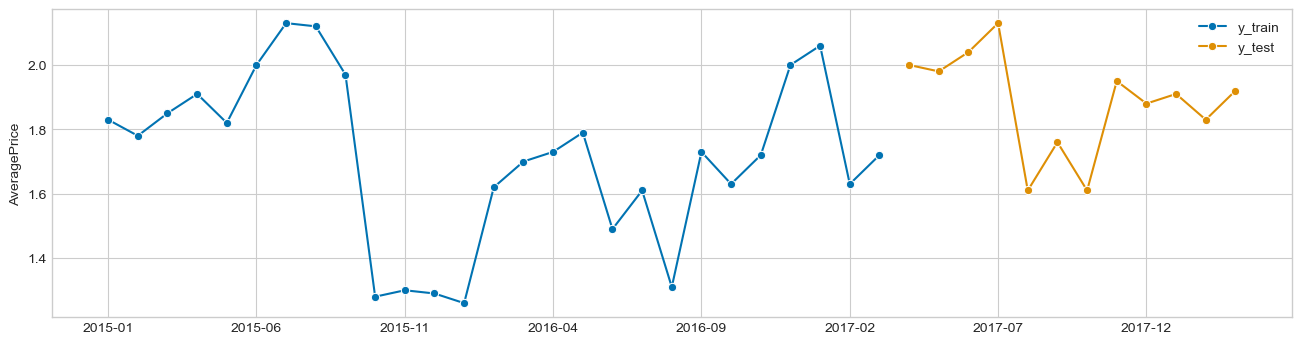

In [9]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

TEST_SIZE = 12
REGION = 'Boston'

y = df[df['Region'] == REGION].sort_index()['AveragePrice'].asfreq('m')

y_train, y_test = temporal_train_test_split(y, test_size = TEST_SIZE)
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

In [10]:
from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon(y_test.index, is_relative=False)

MAPE will be used as a quality metric.

In [12]:
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Predictions and ensemble

Let's build a naive forecast and choose the best of three strategies to build the this forecast

11.724806201550386


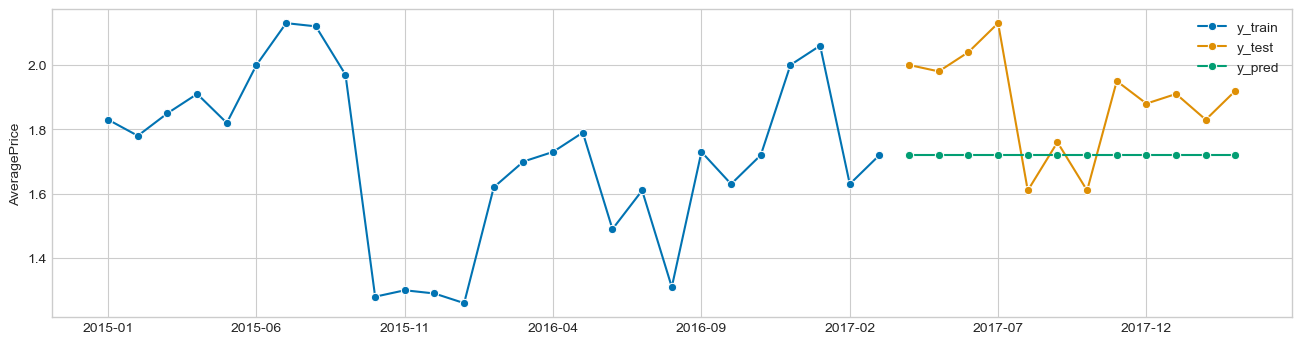

In [17]:
from sktime.forecasting.naive import NaiveForecaster

forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

print(mape(y_pred, y_test))

11.99582252953038


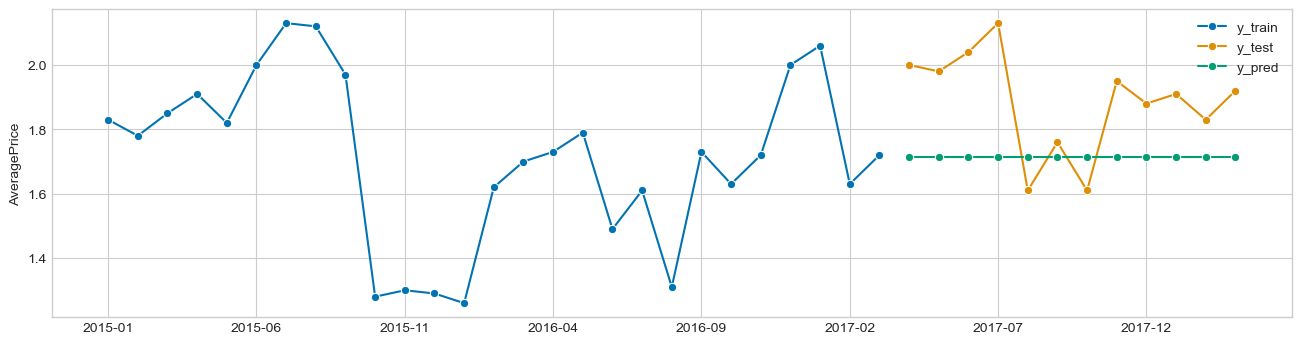

In [18]:
forecaster = NaiveForecaster(strategy="mean")
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

print(mape(y_pred, y_test))

13.024797883073333


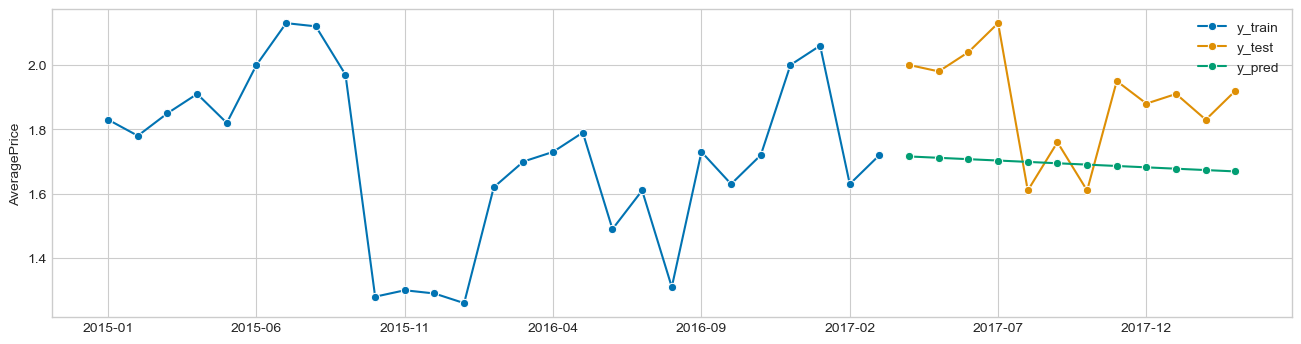

In [19]:
forecaster = NaiveForecaster(strategy="drift")
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

print(mape(y_pred, y_test))

As you can see, the best stategy to build naive forecast is `last`

Let's now train the $ETS(AAA)$ model with the parameter `seasonal=12` and construct a confidence interval for the predictions

In [24]:
import statsmodels.api as sm
ets_aaa = sm.tsa.statespace.ExponentialSmoothing(y_train, trend=True, seasonal=12)
ets_aaa_res = ets_aaa.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95680D-01    |proj g|=  1.23156D+00

At iterate    5    f=  9.33317D-02    |proj g|=  3.57953D+00

At iterate   10    f=  1.24790D-02    |proj g|=  1.33700D-01

At iterate   15    f=  9.81068D-03    |proj g|=  6.45878D-01

At iterate   20    f= -1.81100D-02    |proj g|=  1.20086D-01

At iterate   25    f= -2.31520D-02    |proj g|=  1.92486D-01

At iterate   30    f= -4.09387D-02    |proj g|=  3.29406D-01

At iterate   35    f= -4.56051D-02    |proj g|=  3.25899D-01

At iterate   40    f= -5.81455D-02    |proj g|=  2.03300D+00

At iterate   45    f= -6.28243D-02    |proj g|=  4.78870D-01


 This problem is unconstrained.



At iterate   50    f= -6.34766D-02    |proj g|=  2.10131D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     57      1     0     0   2.101D-02  -6.348D-02
  F =  -6.3476643753459003E-002

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/inreleppik/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [25]:
ets_aaa_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Exponential Smoothing Results                         
==============================================================================
Dep. Variable:           AveragePrice   No. Observations:                   27
Model:                   ETS(A, A, A)   Log Likelihood                   1.714
Date:                Thu, 02 Feb 2023   AIC                             30.572
Time:                        20:27:21   BIC                             52.601
Sample:                    01-31-2015   HQIC                            37.123
                         - 03-31-2017   Scale                            0.052
Covariance Type:                  opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
smoothing_level          0.0001      0.181      0.001      0.999      -0.354       0.354
smoothing_trend          0.0001      0.064      0.002      0.999      -0.126       0.126
smoothing_seasonal       0.0004      0.944      0.000      1.000      -1.850       1.851
initial_level            1.7644      0.497      3.551      0.000       0.791       2.738
initial_trend           -0.0037      0.017     -0.210      0.833      -0.038       0.030
initial_seasonal        -0.0516      0.494     -0.104      0.917      -1.019       0.916
initial_seasonal.L1     -0.1944      0.491     -0.396      0.692      -1.156       0.767
initial_seasonal.L2     -0.2592      0.496     -0.523      0.601      -1.231       0.712
initial_seasonal.L3      0.1354      0.576      0.235      0.814      -0.994       1.265
initial_seasonal.L4      0.0029      0.505      0.006      0.995      -0.987       0.993
initial_seasonal.L5      0.1509      0.494      0.306      0.760      -0.817       1.119
initial_seasonal.L6      0.0253      0.492      0.051      0.959      -0.939       0.990
initial_seasonal.L7      0.0794      4.933      0.016      0.987      -9.590       9.749
initial_seasonal.L8      0.0983      0.668      0.147      0.883      -1.211       1.408
initial_seasonal.L9      0.0484      0.772      0.063      0.950      -1.465       1.562
initial_seasonal.L10    -0.0395      0.736     -0.054      0.957      -1.482       1.403
===================================================================================
Ljung-Box (L1) (Q):                  14.17   Jarque-Bera (JB):                 0.49
Prob(Q):                              0.00   Prob(JB):                         0.78
Heteroskedasticity (H):               2.12   Skew:                            -0.14
Prob(H) (two-sided):                  0.28   Kurtosis:                         2.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

13.152067816798832

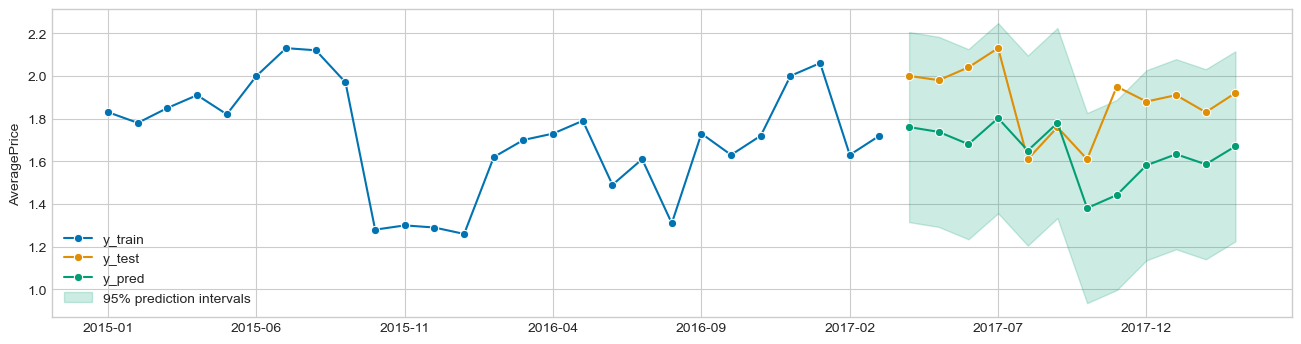

In [26]:
h=12
df_forecast = ets_aaa_res.get_forecast(h).summary_frame()
df_forecast.index = fh
df_forecast.head()
fig, ax = plot_series(y_train, y_test, df_forecast['mean'], labels=["y_train", "y_test", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    df_forecast["mean_ci_lower"],
    df_forecast["mean_ci_upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"95% prediction intervals",
)
ax.legend(loc='lower left');
mape(y_test, df_forecast['mean'])

As you can see, $ETS(AAA)$ don't imporve results of Naive Forecaster. But let's look at the diagnostics  of that model

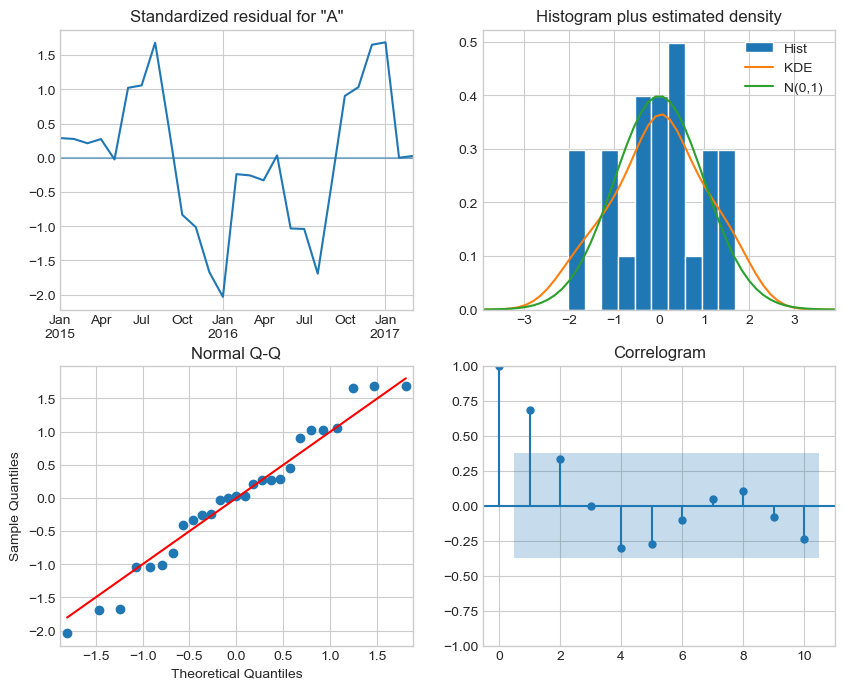

In [23]:
ets_aaa_res.plot_diagnostics(figsize=(10, 8));

- The upper left graph shows the dynamics of the residuals over time around the mean. We can see that the mean is indeed zero. The variance is also normal.

- The bottom right graph is called a correlogram. The autocorrelation is calculated from the data $Corr(u_t, u_{t-s})$. The confidence interval for these correlations is drawn in blue. If the correlation lies within the interval, the hypothesis of its equality to zero is not rejected. Apparently $Corr(u_t, u_{t-1})$ is non-zero. This may be due to the fact that the parameters that are responsible for seasonality were set incorrectly.

- On the secondary diagonal is the distribution of residuals and the quantile-quantile diagram. And it seems that Distributio isn't Normal.

Let's also take a look at $TBATS$ model and $Theta-method$

8.68974358350432

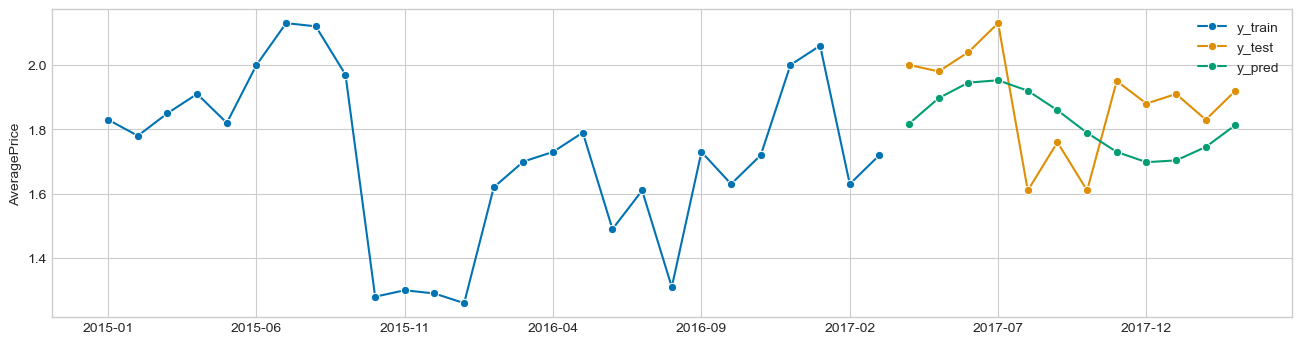

In [29]:
from sktime.forecasting.tbats import TBATS

forecaster = TBATS(sp=12, 
                   use_trend=True, 
                   use_damped_trend=True,
                   use_arma_errors=True,
                   use_box_cox=True)
    
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

mape(y_test, y_pred)

20.31600269689938

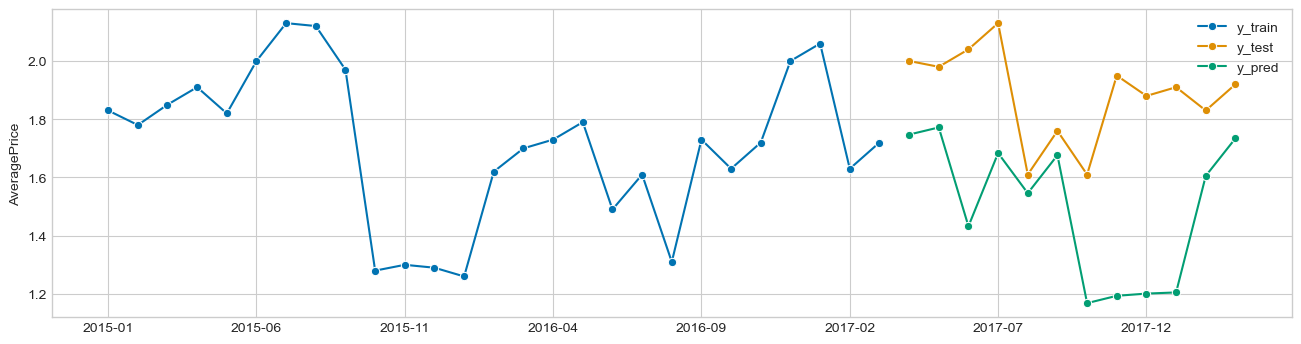

In [30]:
from sktime.forecasting.theta import ThetaForecaster
forecaster = ThetaForecaster(sp=12)

forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

mape(y_test, y_pred)

As you can see, the only model here that improved results of Naive forecast is $TBATS$ model

There is also a possibility to make an Ensemble of models and I just wrote a code for example

12.986312601742817

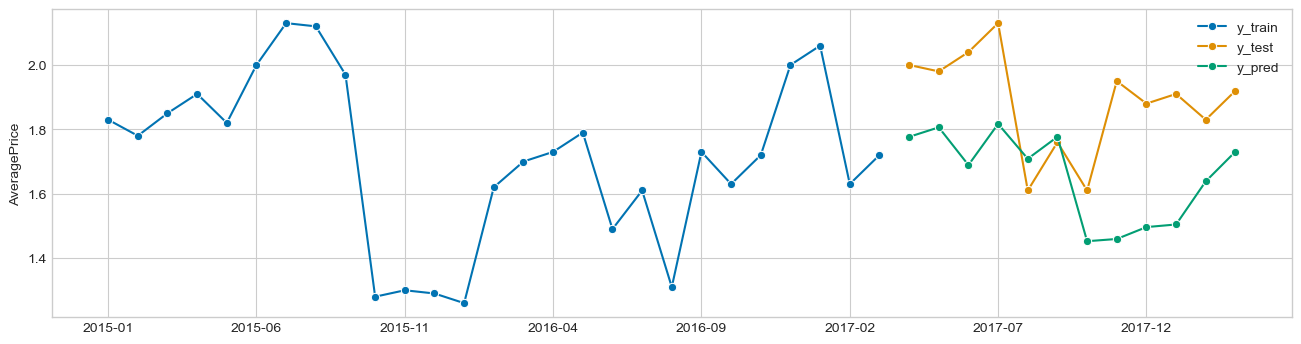

In [31]:
from sktime.forecasting.compose import EnsembleForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing


forecaster = EnsembleForecaster(
    [("ets",   ExponentialSmoothing(trend="add", seasonal="add", sp=12)),
     ("TBATS", TBATS(sp=12, use_trend=True, use_damped_trend=True, use_arma_errors=True, use_box_cox=True)),
     ("Theta", ThetaForecaster(sp=12))
    ]
)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);


mape(y_test, y_pred)

# Cross-validation

It is clear that simply splitting the sample into a trace and a test, and then constructing a prediction for the whole test part is not enough. Such estimates of model quality are not very stable. Moreover, when forecasting for different horizons, we get different errors.
For cross-validation we will use the class [SlidingWindowSplitter,](https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.model_selection.SlidingWindowSplitter.html#sktime.forecasting.model_selection.SlidingWindowSplitter) within the framework of which the sliding window is implemented. In the test sample we will keep three months.

In [33]:
from sktime.forecasting.model_selection import SlidingWindowSplitter

# Cross-validation parametrs
window_length = 27                     # y_train.size
fh = ForecastingHorizon([1, 2, 3])     
fh_length = len(fh)                    

cv_window = SlidingWindowSplitter(window_length=window_length, fh=fh, start_with_window=True)

n_splits = cv_window.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 10


Let's try a cross-validation for the Theta method.

In [34]:
def mape(y_true, y_pred): 
    return np.abs((y_true - y_pred) / y_true)* 100

def cross_val_sccore(forecaster, y, cv=cv_window):
    M = [ ]

    for idx_train, idx_val in cv.split(y):
        
        y_tr = y[idx_train]
        y_val = y[idx_val]
        fh_val = y_val.index
        
        
        
        forecaster.fit(y_tr)
        y_pred = forecaster.predict(fh_val)
       
        
        
        M.append(mape(y_val, y_pred).values)
        
    return np.array(M)

M = cross_val_sccore(ThetaForecaster(sp=12), y)
quality = M.mean(axis=0)
quality

array([11.0896312 , 14.67886759, 14.90843771])

The quality vector records three different MAPE values of our model when forecasting one month, two months, and three months ahead.

Let's run a cross validation on all the models from the list below and see which one predicts the best for different time intervals

In [35]:
from sktime.forecasting.ets import AutoETS

forecaster_1 = NaiveForecaster(strategy="last")
forecaster_2 = NaiveForecaster(strategy="mean", window_length=12)
forecaster_3 = NaiveForecaster(strategy="last", sp=12)

forecaster_4 = ThetaForecaster(sp=12)
forecaster_5 = AutoETS(auto=True, sp=12, n_jobs=-1, information_criterion='bic')

forecaster_6 = TBATS(sp=12, 
                   use_trend=True, 
                   use_damped_trend=True,
                   use_arma_errors=True,
                   use_box_cox=True)

fc = [forecaster_1, forecaster_2, forecaster_3,
     forecaster_4, forecaster_5, forecaster_6]

In [48]:
dff = pd.DataFrame(columns = ['Forecaster','MAPE_1', 'MAPE_2', 'MAPE_3'])
from tqdm.notebook import tqdm
j=1
for i in tqdm(np.arange(6)):
    M=0
    M = cross_val_sccore(fc[i], y)
    M = M.mean(axis=0)
    dff.loc[i] = ['forecaster_{num:}'.format(num=j), M[0], M[1], M[2]]
    j += 1
print("Best forecast for next month: " + dff[dff.MAPE_1 == dff.MAPE_1.min()].Forecaster[dff[dff.MAPE_1 == dff.MAPE_1.min()].index[0]],
     "Best forecast for next 2 months: " + str(dff[dff.MAPE_2 == dff.MAPE_2.min()].Forecaster[dff[dff.MAPE_2 == dff.MAPE_2.min()].index[0]]),
     "Best forecast for next 3 months: " + str(dff[dff.MAPE_3 == dff.MAPE_3.min()].Forecaster[dff[dff.MAPE_3 == dff.MAPE_3.min()].index[0]]), sep='\n')

  0%|          | 0/6 [00:00<?, ?it/s]

Best forecast for next month: forecaster_5
Best forecast for next 2 months: forecaster_6
Best forecast for next 3 months: forecaster_2


In [30]:
dff

,Forecaster,MAPE_1,MAPE_2,MAPE_3
0,forecaster_1,9.504425,9.879693,14.114455
1,forecaster_2,10.056734,8.772524,7.315006
2,forecaster_3,12.208146,11.951043,12.033113
3,forecaster_4,11.089631,14.678868,14.908438
4,forecaster_5,8.780544,10.665282,12.965998
5,forecaster_6,10.352422,8.265548,8.886308


It is also possible to cross validate these models for all cities and make a table with the results

The code that does all this is given below

In [ ]:
dffc = pd.DataFrame(columns = ['Region', 'Forecaster','MAPE_1', 'MAPE_2', 'MAPE_3'])
for i in tqdm(df.Region.unique()):
        Y = df[df.Region == i].sort_index()['AveragePrice'].asfreq('m')
        forecaster_1 = NaiveForecaster(strategy="last")
        forecaster_2 = NaiveForecaster(strategy="mean", window_length=12)
        forecaster_3 = NaiveForecaster(strategy="last", sp=12)
        forecaster_4 = ThetaForecaster(sp=12)
        forecaster_5 = AutoETS(auto=True, sp=12, n_jobs=-1, information_criterion='bic')
        forecaster_6 = TBATS(sp=12, 
                             use_trend=True, 
                             use_damped_trend=True,
                             use_arma_errors=True,
                             use_box_cox=True)
        fc = [forecaster_1, forecaster_2, forecaster_3,
              forecaster_4, forecaster_5, forecaster_6]
        k = 1
        
        for j in tqdm(np.arange(len(fc))):
            M=0
            M = cross_val_sccore(fc[j], Y)
            M = M.mean(axis=0)
            dffc.loc[len(dffc)] = [i ,'forecaster_{num:}'.format(num=k), M[0], M[1], M[2]]
            k += 1

In [ ]:
dffc.head()

In [ ]:
dffc.groupby('Forecaster').mean()